In [1]:
import numpy as np
import pprint, os

from physion.intrinsic.analysis import *

from datavyz import graph_env_notebook as ge

 /!\  "svgutils" not installed ! get it with: "pip install svgutils" 


In [2]:
FOLDERS = []
root_datafolder = os.path.join(os.path.expanduser('~'), 'UNPROCESSED', 'intrinsic')
for df in os.listdir(root_datafolder):
    for tf in os.listdir(os.path.join(root_datafolder, df)):
        FOLDERS.append(os.path.join(root_datafolder, df, tf))
        print(len(FOLDERS)-1, ') ', len(os.listdir(FOLDERS[-1])))

0 )  21
1 )  19
2 )  12
3 )  6
4 )  27
5 )  30
6 )  16
7 )  5
8 )  5
9 )  12


In [127]:
data['metadata']

KeyError: 'metadata'

In [128]:
def init_data(datafolder,
              spatial_subsampling=0):
    
    data = {}

    # # determining sampling time
    success = True
    for (l1, l2) in [('up', 'down'), ('left', 'right')]:
        try:
            io1 = pynwb.NWBHDF5IO(os.path.join(datafolder, '%s-1.nwb' % l1), 'r')
            io2 = pynwb.NWBHDF5IO(os.path.join(datafolder, '%s-1.nwb' % l2), 'r')
            nwbfile1, nwbfile2 = io1.read(), io2.read()
            imshape = resample_img(nwbfile1.acquisition['image_timeseries'].data[0,:,:], spatial_subsampling).shape
            t = nwbfile1.acquisition['image_timeseries'].timestamps[:]
            for l in [l1, l2]:
                data[l] = {'t':[], 'movie':[], 'angle':[]}
            data['dt'] = t[1]-t[0]
            data['imshape'] = imshape
            io1.close()
            io2.close()
        except BaseException as be:
            print(be)
            success = False

    if success:
        return data
    else:
        return None

def get_data(datafolder,
             spatial_subsampling=0,
             temporal_smoothing=0,
             exclude=[],
             std_exclude_factor=100.):

    data = init_data(datafolder, spatial_subsampling=spatial_subsampling)
    data['folder'] = datafolder
    if data is not None:
        
        # load metadata
        if os.path.isfile(os.path.join(datafolder, 'metadata.npy')):
            data['metadata'] = np.load(os.path.join(datafolder, 'metadata.npy'), allow_pickle=True).item()
        
        # average all data across recordings
        for l, label in enumerate(['up', 'down', 'left', 'right']):
            i=1
            while os.path.isfile(os.path.join(datafolder, '%s-%i.nwb' % (label, i))):
                include = True
                for e in exclude:
                    if e in '%s-%i.nwb' % (label, i):
                        include = False

                if include:
                    io = pynwb.NWBHDF5IO(os.path.join(datafolder, '%s-%i.nwb' % (label, i)), 'r')
                    nwbfile = io.read()
                    movie = nwbfile.acquisition['image_timeseries'].data[:,:,:]

                    for j in range(movie.shape[0]):
                        data[label]['movie'].append(resample_img(movie[j,:,:], spatial_subsampling))
                        data[label]['angle'].append(nwbfile.acquisition['angle_timeseries'].data[j])
                    
                i+=1
                
            data[label]['movie'] = np.array(data[label]['movie'])
            data[label]['t'] = np.arange(data[label]['movie'].shape[0])*data['dt']
            data[label]['nrepeat'] = i-1
            
        compute_maps(data)
        
        
        
        return data
    else:
        return None
    
def perform_fft_analysis(data, direction):
    
    spectrum = np.fft.fft(data[direction]['movie'], axis=0)
    power, phase = np.abs(spectrum), np.angle(spectrum)
    
    return power[data[direction]['nrepeat'], :, :], phase[data[direction]['nrepeat'], :, :]

def compute_maps(data):
    # compute maps
    for l, label in enumerate(['up', 'down', 'left', 'right']):
        power, phase = perform_fft_analysis(data, label)
        data[label]['power_map'] = power
        data[label]['phase_map'] = phase

    # altitude map
    data['altitude_delay_map'] = 0.5*(data['up']['phase_map']-data['down']['phase_map'])
    data['altitude_power_map'] = 0.5*(data['up']['power_map']+data['down']['power_map'])

    # azimuthal map
    data['azimuth_delay_map'] = 0.5*(data['left']['phase_map']-data['right']['phase_map'])
    data['azimuth_power_map'] = 0.5*(data['left']['power_map']+data['right']['power_map'])


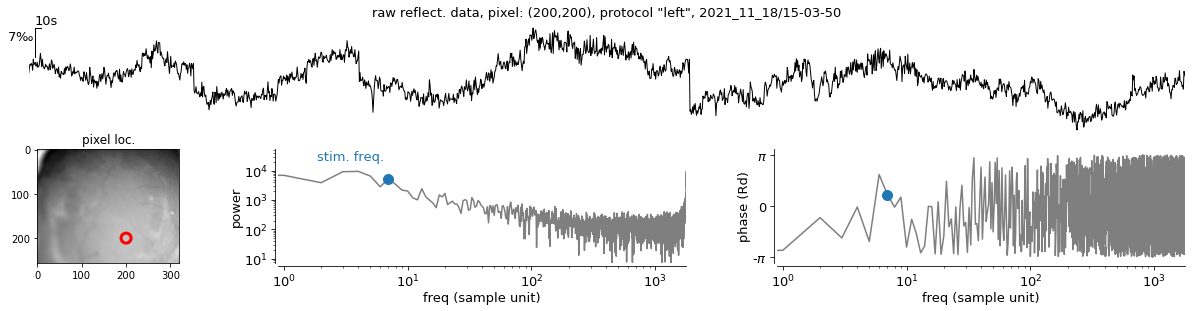

In [160]:

def show_raw_data(data, pixel=(200,200), direction='down'):
    
    fig, AX = ge.figure(axes_extents=[[[5,1]],[[1,1],[2,1],[2,1]]], hspace=0.2)
    
    AX[0][0].plot(data[direction]['t'], data[direction]['movie'][:,pixel[0], pixel[1]], 'k', lw=1)
    yscale=np.diff(AX[0][0].get_ylim())[0]/4.
    ge.draw_bar_scales(AX[0][0], Xbar=10, Xbar_label='10s', Ybar=yscale, 
                      Ybar_label='$%.0f\perthousand$' % (1000*yscale/data[direction]['movie'][:,pixel[0], pixel[1]].mean()))
    ge.set_plot(AX[0][0], [], xlim=[0, data[direction]['t'][-1]], 
                title='raw reflect. data, pixel: (%i,%i), protocol "%s", %s' % (*pixel, direction, 
                                                                              '202'+data['folder'].split('202')[1]))
    
    AX[1][0].imshow(data[direction]['movie'][0,:,:], cmap='gray')
    AX[1][0].scatter([pixel[0]], [pixel[1]], s=100, color='none', edgecolor='r', lw=3)
    AX[1][0].set_title('pixel loc.')
    
    spectrum = np.fft.fft(data[direction]['movie'][:,pixel[0], pixel[1]], axis=0)
    power, phase = np.abs(spectrum), np.angle(spectrum)
    AX[1][1].plot(power, color=ge.gray)
    AX[1][1].plot([data[direction]['nrepeat']], [power[data[direction]['nrepeat']]], 'o', color=ge.blue, ms=10)
    ge.annotate(AX[1][1], 'stim. freq. \n', (data[direction]['nrepeat'], power[data[direction]['nrepeat']]), 
                color=ge.blue, xycoords='data', ha='right')
    AX[1][2].plot(phase, color=ge.gray)
    AX[1][2].plot([data[direction]['nrepeat']], [phase[data[direction]['nrepeat']]], 'o', color=ge.blue, ms=10)
    ge.set_plot(AX[1][1], xscale='log', yscale='log', 
                ylim=[power.min(), 10*power[data[direction]['nrepeat']]],
                xlabel='freq (sample unit)', ylabel='power', xlim=[0.9, len(power)])
    ge.set_plot(AX[1][2], xscale='log', xlabel='freq (sample unit)', ylabel='phase (Rd)', yticks=[-np.pi, 0, np.pi],
                yticks_labels=['-$\pi$', '0', '$\pi$'], xlim=[0.9, len(power)])
    
    return fig
    
ge.save_on_desktop(show_raw_data(DATA[0], (200,200), 'left'), 'fig.png')
#show_raw_data(DATA[1], (250,210), 'down')
#show_raw_data(DATA[1], (250,210), 'right')
#show_raw_data(DATA[1], (250,210), 'left')

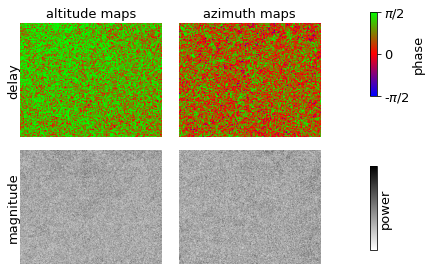

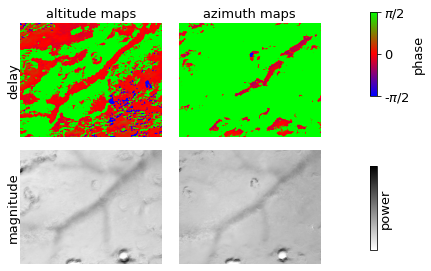

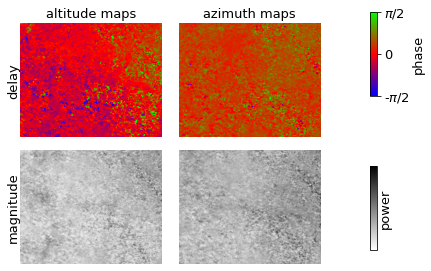

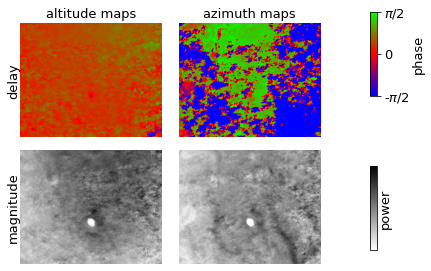

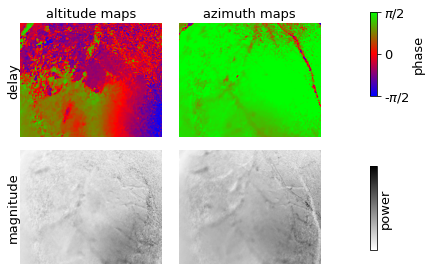

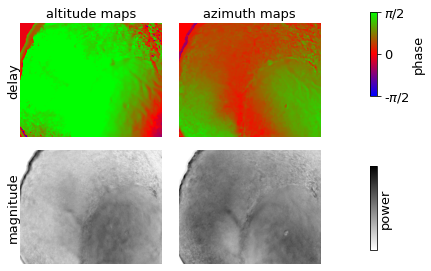

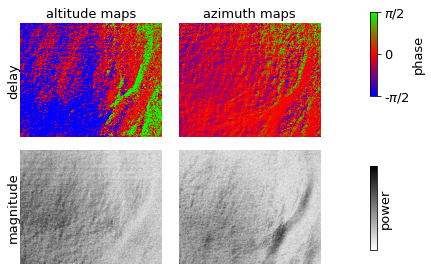

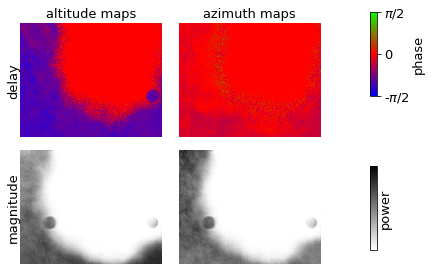

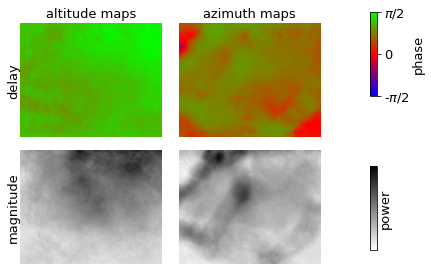

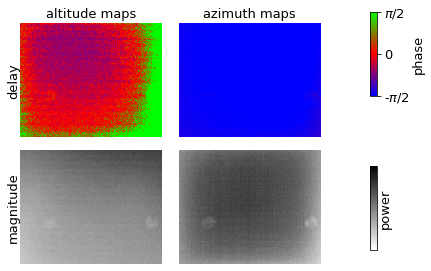

In [173]:
DATA = []
for f in FOLDERS:
    data = get_data(f)
    show_retinotopic_maps(data)

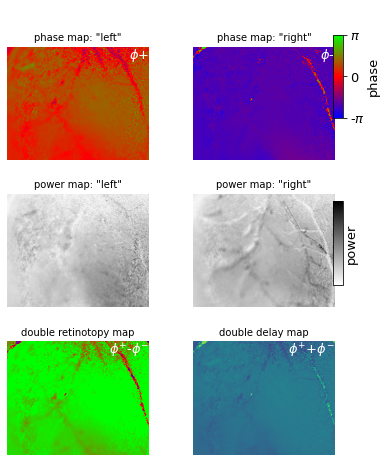

In [172]:
def show_single_cond_maps(data, direction='azimuthal'):
    
    if direction=='altitude':
        plus, minus = 'up', 'down'
    else:
        plus, minus = 'left', 'right'
        
    fig, AX = ge.figure(axes=(2,3), top=1, wspace=0.3, hspace=0.5, right=3)
    ge.annotate(AX[0][0], '%s maps' % direction, (0.5,1), ha='center', va='top', 
                xycoords='figure fraction', size='small')
    
    AX[0][0].imshow(data[plus]['phase_map'], cmap=plt.cm.brg, vmin=-np.pi, vmax=np.pi)
    AX[0][1].imshow(data[minus]['phase_map'], cmap=plt.cm.brg, vmin=-np.pi, vmax=np.pi)
    ge.annotate(AX[0][0], '$\phi$+', (1,1), ha='right', va='top', color='w')
    ge.annotate(AX[0][1], '$\phi$-', (1,1), ha='right', va='top', color='w')
    ge.title(AX[0][0], 'phase map: "%s"' % plus, size='xx-small')
    ge.title(AX[0][1], 'phase map: "%s"' % minus, size='xx-small')
    ge.bar_legend(fig, X=[-np.pi, 0, np.pi], label='phase', 
                  colormap=plt.cm.brg, continuous=True,
                  ticks=[-np.pi, 0, np.pi], ticks_labels=['-$\pi$', '0', '$\pi$'],
                  bounds=[-np.pi, np.pi], 
                  colorbar_inset=dict(rect=[.85,.8,.02,.15], facecolor=None))
    
    AX[1][0].imshow(data[plus]['power_map'], cmap=plt.cm.binary)
    AX[1][1].imshow(data[minus]['power_map'], cmap=plt.cm.binary)
    ge.title(AX[1][0], 'power map: "%s"' % plus, size='xx-small')
    ge.title(AX[1][1], 'power map: "%s"' % minus, size='xx-small')
    ge.bar_legend(fig, label='power', colormap=plt.cm.binary,
                  colorbar_inset=dict(rect=[.85,.5, .02,.15], facecolor=None))
    
    AX[2][0].imshow(data[plus]['phase_map']-data[minus]['phase_map'], cmap=plt.cm.brg, vmin=-np.pi, vmax=np.pi)
    AX[2][1].imshow(data[plus]['phase_map']+data[minus]['phase_map'], cmap=plt.cm.viridis)
    ge.annotate(AX[2][0], '$\phi^{+}$-$\phi^{-}$', (1,1), ha='right', va='top', color='w')
    ge.annotate(AX[2][1], '$\phi^{+}$+$\phi^{-}$', (1,1), ha='right', va='top', color='w')
    ge.title(AX[2][0], 'double retinotopy map', size='xx-small')
    ge.title(AX[2][1], 'double delay map', size='xx-small')
    
    for ax in ge.flat(AX):
        ax.axis('off')
        
    return fig

ge.save_on_desktop(show_single_cond_maps(DATA[0],  'azimuth'), 'fig.png')
#fig = show_maps(DATA[1],  'azimuthal')


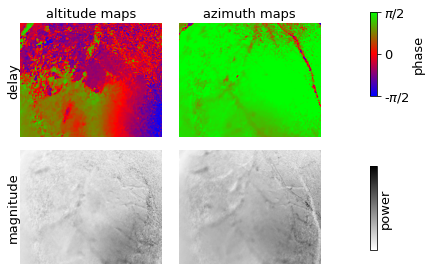

In [171]:
def show_retinotopic_maps(data):
    
    fig, AX = ge.figure(axes=(2,2), top=1, wspace=0., hspace=0.2, right=6, bottom=0, left=0.2)
    
    ge.title(AX[0][0], 'altitude maps')
    ge.title(AX[0][1], 'azimuth maps')
    ge.annotate(AX[0][0], 'delay', (0,0.5), ha='right', va='center', rotation=90)
    ge.annotate(AX[1][0], 'magnitude', (0,0.5), ha='right', va='center', rotation=90)
    
    AX[0][0].imshow(data['altitude_delay_map'], cmap=plt.cm.brg, vmin=-np.pi/2, vmax=np.pi/2)
    AX[0][1].imshow(data['azimuth_delay_map'], cmap=plt.cm.brg, vmin=-np.pi/2, vmax=np.pi/2)
    
    ge.bar_legend(fig, X=[-np.pi, 0, np.pi], label='phase', 
                  colormap=plt.cm.brg, continuous=True,
                  ticks=[-np.pi, 0, np.pi], ticks_labels=['-$\pi$/2', '0', '$\pi$/2'],
                  bounds=[-np.pi, np.pi], 
                  colorbar_inset=dict(rect=[.8,.6,.015,.3], facecolor=None))
    
    AX[1][0].imshow(data['altitude_power_map'], cmap=plt.cm.binary)
    AX[1][1].imshow(data['azimuth_power_map'], cmap=plt.cm.binary)
    ge.bar_legend(fig, label='power', colormap=plt.cm.binary,
                  colorbar_inset=dict(rect=[.8,.05, .015,.3], facecolor=None))
    
    
    for ax in ge.flat(AX):
        ax.axis('off')
        
    return fig

ge.save_on_desktop(show_retinotopic_maps(DATA[0]), 'fig.png')

# Visual Area segmentation

Copied from:
    
https://nbviewer.org/github/zhuangjun1981/retinotopic_mapping/blob/master/retinotopic_mapping/examples/signmap_analysis/retinotopic_mapping_example.ipynb
    
    
/!\ Cite the original implementation/work by Jun Zhuang: *Zhuang et al., Elife 2017*

https://elifesciences.org/articles/18372


In [58]:
from NeuroAnalysisTools import RetinotopicMapping as rm

In [113]:
     

params = {
          'phaseMapFilterSigma': 2,
          'signMapFilterSigma': 15.,
          'signMapThr': 0.1,
          'eccMapFilterSigma': 15.0,
          'splitLocalMinCutStep': 5.,
          'closeIter': 3,
          'openIter': 3,
          'dilationIter': 15,
          'borderWidth': 1,
          'smallPatchThr': 100,
          'visualSpacePixelSize': 0.5,
          'visualSpaceCloseIter': 15,
          'splitOverlapThr': 1.1,
          'mergeOverlapThr': 0.1
          }

### Generating visual sign map

In [142]:
data = DATA[0]
trial = rm.RetinotopicMappingTrial(altPosMap=data['altitude_delay_map']*40/np.pi*2,
                                   aziPosMap=data['azimuth_delay_map']*40/np.pi*2,
                                   altPowerMap=data['altitude_power_map']*10,
                                   aziPowerMap=data['azimuth_power_map']*10,
                                   vasculatureMap=data['up']['movie'][0,:,:],
                                   mouseID=data['metadata']['subject'].replace('Mouse', 'ouse'),
                                   dateRecorded='202'+data['folder'].split('202')[1],
                                   comments='This is an example.',
                                   params=params)

In [143]:
print(trial)

A retinotopic mapping trial: 2021_11_18/15-03-50_Mouse3_SSTCre


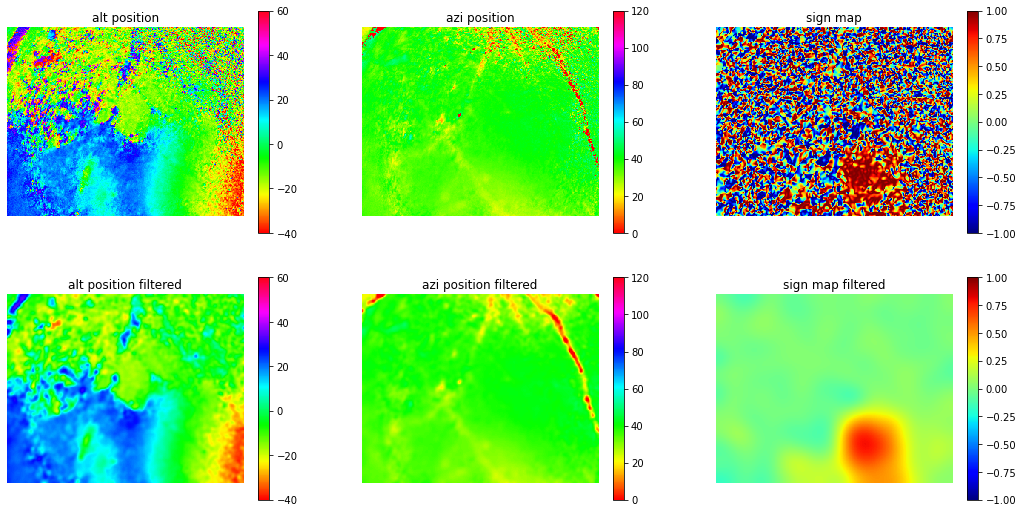

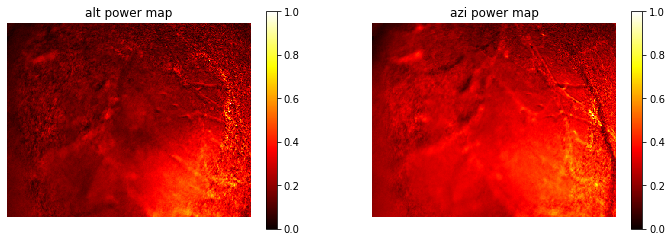

In [144]:
_ = trial._getSignMap(isPlot=True)
plt.show()

### Binarizing filtered visual signmap

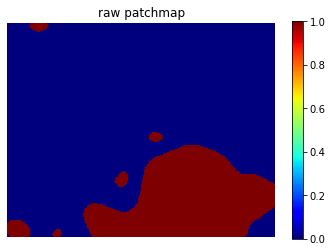

In [117]:
_ = trial._getRawPatchMap(isPlot=True)

### Generating raw patches

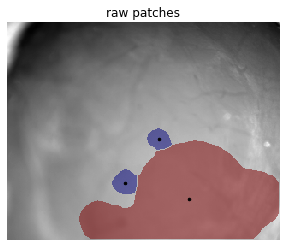

In [118]:
_ = trial._getRawPatches(isPlot=True)

### Generating determinant map

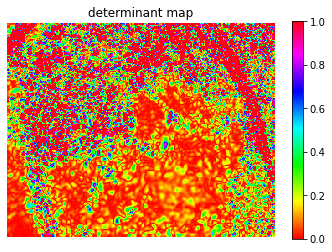

In [119]:
_ = trial._getDeterminantMap(isPlot=True)

### Generating eccentricity map for each patch

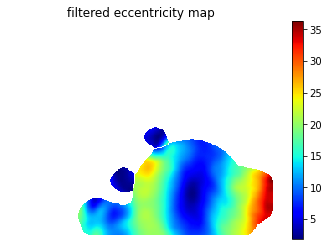

In [120]:
_ = trial._getEccentricityMap(isPlot=True)

patch01AU=843.75 AS=2113.4701029433945 ratio=2.5048534553403194
4 local minuma were found!!!
patch02AU=54.75 AS=66.53609108510497 ratio=1.2152710700475793
Only one local minumum was found!!!
patch03AU=51.75 AS=71.97621652240016 ratio=1.3908447637178776
Only one local minumum was found!!!


/home/yann.zerlaut/miniconda3/envs/physion/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
/home/yann.zerlaut/miniconda3/envs/physion/lib/python3.7/site-packages/NeuroAnalysisTools/RetinotopicMapping.py:397: RuntimeWarning: invalid value encountered in less_equal
  marker[eccMap2 <= (currThr)] = 1


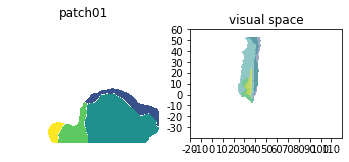

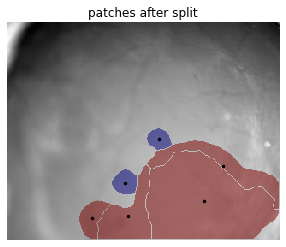

In [121]:
_ = trial._splitPatches(isPlot=True)

merge iteration: 1


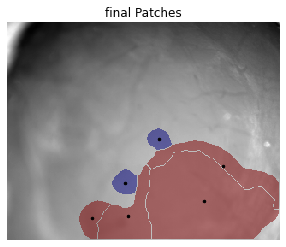

In [122]:
_ = trial._mergePatches(isPlot=True)

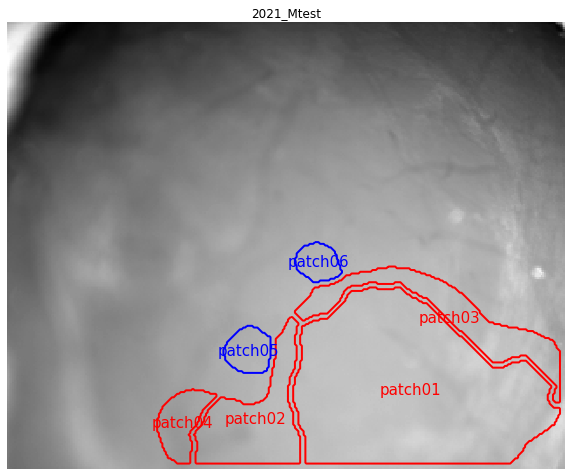

In [123]:
_ = trial.plotFinalPatchBorders2()

# Demo of FFT analysis of periodic stimulation

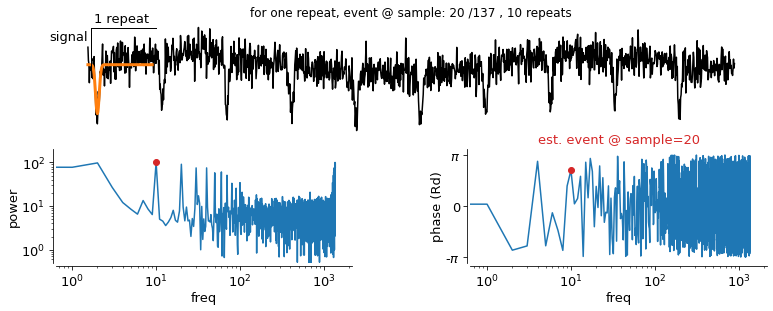

In [145]:
# demo of analysis motivation
from datavyz import graph_env_notebook as ge
import numpy as np

max_sample = 20

def from_angle_to_fraction(angle):
    return -(angle-np.pi)/2./np.pi
    
def demo_fig(max_sample,
             nrepeat=10,
             n_sample_per_repeat= 137,
             noise_fraction=0.2,
             slow_fraction=0.2,
             seed=10):
    
    np.random.seed(seed)
    fig, AX = ge.figure(axes_extents=[[[2,1]],[[1,1],[1,1]]], figsize=(1.4,1), wspace=0.7, hspace=0.2)
    x = -np.exp(-(np.arange(n_sample_per_repeat)-max_sample)**2/30)+3500
    X = np.concatenate([x for n in range(nrepeat)])
    X += noise_fraction*np.random.randn(len(X))+slow_fraction*np.sin(np.linspace(0, 10, len(X)))
    AX[0][0].plot(X, 'k-')
    AX[0][0].plot(x, lw=3, color=ge.orange)
    ge.draw_bar_scales(AX[0][0], Xbar=n_sample_per_repeat, Xbar_label='1 repeat', Ybar=1, Ybar_label='signal', remove_axis=True)
    ge.title(AX[0][0], 'for one repeat, event @ sample: %i /%i , %i repeats' % (max_sample, n_sample_per_repeat, nrepeat), size='small')
    spectrum = np.fft.fft(X)
    power, phase = np.abs(spectrum), np.angle(spectrum)
    AX[1][0].plot(power)
    AX[1][0].plot([nrepeat], [power[nrepeat]], 'o', color=ge.red)
    AX[1][1].plot(phase)
    AX[1][1].plot([nrepeat], [phase[nrepeat]], 'o', color=ge.red)
    ge.title(AX[1][1], 'est. event @ sample=%i' % (from_angle_to_fraction(phase[nrepeat])*n_sample_per_repeat), color=ge.red)
    ge.set_plot(AX[1][0], xscale='log', yscale='log', ylim=[power.min(), 2*power[nrepeat]],
                xlabel='freq', ylabel='power')
    ge.set_plot(AX[1][1], xscale='log', xlabel='freq', ylabel='phase (Rd)', yticks=[-np.pi, 0, np.pi],
               yticks_labels=['-$\pi$', '0', '$\pi$'])
    return fig

demo_fig(20, seed=3);

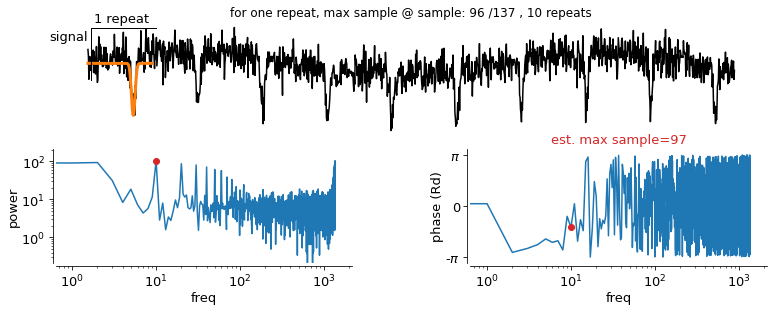

In [23]:
demo_fig(96);

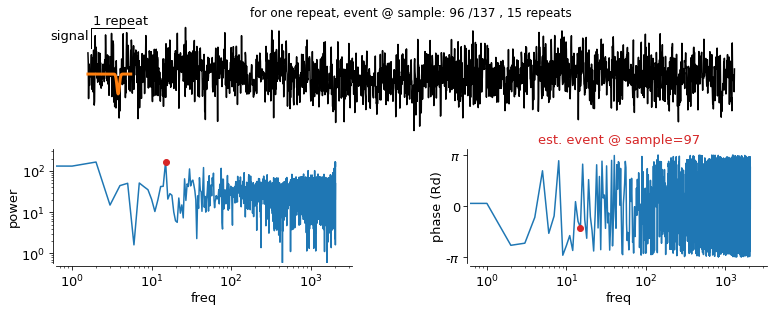

In [147]:
ge.save_on_desktop(demo_fig(96, noise_fraction=0.8, nrepeat=15), 'fig.png')